# Maximize the profit of an semiconductor company
this explains the way we set decision optimization engine for company profit optimization based on a demand forecast, marketing campaign upsell/cost, selling price, production/material cost, and several types of products and material sets combinations.

![test](https://firebasestorage.googleapis.com/v0/b/mionosuke-db.appspot.com/o/category%2Fmionosuke_category.png?alt=media&token=e818b9c9-1685-42a4-80a7-19e2d65f3b2a)

## Assumptions
1. **High level overview:**  
    1. Semiconductor company manufactures different types of products for different market segment : mobile, client, and server. Each types of product is assembled by integrating different types of Si chips that must be either purchased(outsource) or internally manufactured. The company would like to maximize their profit
    1. The chip integration problem (a.k.a dissaggregation) consists of calculating different combinations of chips according to specific performance criteria from each market segment
1. **Market segmentation:**
    1. Three types of products are manufactured : mobile, client, and server
    1. Each type of product is manufactured by integrating three types of Silicone: internal_gen1, internal_gen2, and external_gen3
1. **Requirement Spec:**
    1. The product must satisfy some performance criteria with respect to their core count and  power delivery, thus constraining the possible integrations
    1. The company must also satisfy its customer demand, which is 3,000 units/day of mobile, 2,000 units/day of client, and 1,000 units/day of server
1. **Constraints:**
    1. The company can manufacture 5,000 units of each type of Silicone per day and can internally process at most 8,000 units a day
    1. The company can purchase 6,000 units of external Silicone per day
    1. The company can assembles Silicons into products 12,000 units a day with the combination of internal and external Silicon
1. **Opportunity:**
    1. In addition, the company has the option of advertising a product, in which case the demand for this type of product increases by 10 units for every dollar spent
1. **Manufacturing Assumption:**
    1. Finally, it costs 4 dollars for mobile, 8 dollars for client, and 20 dollars for servers to manufacture a product for assembly/test (assume yield loss are included)

## Frame : Prescriptive analysis
1. Prescriptive analysis recommends actions based on desired outcomes, taking into account specific scenarios, ressources, and knowledge of past and current events. This insight can help organization make better decisions and have greater control of business outcomes, giving org a strong competitive advantage
1. Prescriptive analysis requires to set constraints as well as variables as its model development

* Use Cases;  
    1. Automate complex decisions and trade-offs to better manage limited resources (ie. portfolio)
    1. Take advantage of a future opportunity or mitigate a future risk
    1. Proactively update recommendations based on changing events/assumptions
    1. Meet operational goals, increase customer loyalty, prevent threats and fraud, and optimize business processes


## Use decision optimization

1. [Step 1 : Import the library](#Step-1-:-Import-the-library)
1. [Step 2 : Model the data](#Step-2-:-Model-the-data)
1. [Step 3 : Set up the prescriptive model : Optimization model and Variables](#Step-3-:-Set-up-the-prescriptive-model-:-Optimization-model-and-Variables)
1. [Step 4 : Set up the prescriptive model : Constraints](#Step-4-:-Set-up-the-prescriptive-model-:-Constraints)
1. [Step 5 : Express the objective](#Step-5-:-Express-the-objective)
1. [Step 6 : Investigate the solution](#Step-6-:-Investigate-the-solution)

### Step 1 : Import the library
[<<back](#Use-decision-optimization)  
The Docplex library contains the two modeling packages, Mathematical Programming (docplex.mp) and Constraint Programming (docplex.cp). This what-ifs would use mathematical programming

In [1]:
import sys
try:
    import docplex.mp
except:
    raise Exception('Please install docplex')

In [2]:
try:
    import cplex
except:
    raise Exception('Please install cplex')

### Step 2 : Model the data

[<<back](#Use-decision-optimization)  
Contain data into 2 dimemsional numpy array

In [3]:
import numpy as np

# types of product
pr_names = ['mobile', 'client', 'server']

# data for each product type; capacity requirement(u/day), selling price ($/u),
# core count, power delivery, and manufacturing cost ($/u)
pr_data = np.array([[3000, 30, 5, 3, 3], [2000, 60, 10, 5, 6], [1000, 200, 50, 10, 20]])

# types of silicon
si_names = ['int_g1', 'int_g2', 'ext_g3']

# data for each si type; capacity can be manufactured(or purchased) (u/day), cost($/u), core count and power delivery
si_data = np.array([[10000, 3, 1, 1], [8000, 4, 2, 2], [12000, 10, 5, 3]])

In [4]:
# length and range for product and silicon, which will be used for variable setting
nb_pr = len(pr_names)
nb_si = len(si_names)
range_pr = range(nb_pr)
range_si = range(nb_si)

# internal Si
# internal si is currently manually sorted
nb_si_int = len(si_names) - 1
range_si_int = range(nb_si_int)

print('Number of products types = {0}'.format(nb_pr))
print('Number of silicon types = {0}'.format(nb_si))
print('Number of internal silicon types = {0}'.format(nb_si_int))

Number of products types = 3
Number of silicon types = 3
Number of internal silicon types = 2


In [5]:
# global data

# internal production limit per day (u/day) : int_g1 + int_g2
production_max = 20000

# advertisement oppy : each $1 spent on advertising increases demand by 0.05 units (UoM : u/$, 1/0.05 = $20 equivalent!)
advert_return = 0.05

#### Prepare the data
convert numpy to pandas

In [6]:
# product table
import pandas as pd
prpd = pd.DataFrame([(pr_names[i], int(pr_data[i][0]), int(pr_data[i][1]), int(pr_data[i][2]),
                       int(pr_data[i][3]), int(pr_data[i][4]))
                      for i in range_pr])
prpd.columns = ['name', 'demand', 'price', 'core', 'pd', 'mfg cost']

In [7]:
prpd

,name,demand,price,core,pd,mfg cost
0,mobile,3000,30,5,3,3
1,client,2000,60,10,5,6
2,server,1000,200,50,10,20


In [8]:
# silicon table
sipd = pd.DataFrame([(si_names[i], int(si_data[i][0]), int(si_data[i][1]), int(si_data[i][2]), int(si_data[i][3]))
                      for i in range_si])
sipd.columns = ['name', 'capacity', 'cost', 'core', 'pd']

In [9]:
sipd

,name,capacity,cost,core,pd
0,int_g1,10000,3,1,1
1,int_g2,8000,4,2,2
2,ext_g3,12000,10,5,3


### Step 3 : Set up the prescriptive model : Optimization model and Variables
[<<back](#Use-decision-optimization)  
#### Create the docplex model
A model is needed to store all the variables and constraints needed to formulate the business problem and submit the problem to the solve service

In [10]:
from docplex.mp.model import Model
mdl = Model(name='product_mix')

#### Define the decision variables
For each combination of silicon and product, we have to decide the quantity of silicon chip to use to produce a product. A decision variable will be needed to represent that amount. A matrix of integer variables, indexed by the set of silicon and the set of product needs to be created

In [11]:
# lb(lower bound) can be set by variable, and use a list in the case, ex) lb = [0,0,0,1,1,1,2,2,2]
# nb_si x nb_pr matrix = 9 vars
# unit of measure : units
# Silicon mix variables against products
mix = mdl.continuous_var_matrix(keys1 = nb_si, keys2 = nb_pr, lb = 0)

In [12]:
# example;
# (0,0) : int_gen1 mix for mobile
# (0,1) : int_gen1 mix for client
# (0,2) : int_gen1 mix for server
mix

{(0, 0): docplex.mp.Var(type=C),
 (0, 1): docplex.mp.Var(type=C),
 (0, 2): docplex.mp.Var(type=C),
 (1, 0): docplex.mp.Var(type=C),
 (1, 1): docplex.mp.Var(type=C),
 (1, 2): docplex.mp.Var(type=C),
 (2, 0): docplex.mp.Var(type=C),
 (2, 1): docplex.mp.Var(type=C),
 (2, 2): docplex.mp.Var(type=C)}

We also have to dedcide how much should be spent on products in advertising for each type of product. To do so, we will create a list of continuous variables, indexed by the products type

In [13]:
# nb_pr = 3
# unit of measure : dollar (advertising cost)
# var : $ spent for mobile, $ spent for client, and $ spent for server
adverts = mdl.continuous_var_list(nb_pr, lb = 0)

In [14]:
adverts

[docplex.mp.Var(type=C), docplex.mp.Var(type=C), docplex.mp.Var(type=C)]

### Step 4 : Set up the prescriptive model : Constraints
[<<back](#Use-decision-optimization)  
#### Express the business constraints
The business constraints are the following:
1. The capacity constraint on each Si type must also be satisfied
1. The total internal Si production has to be the maximum production capacity (<= 8,000)
1. For each product type, the core count must be above a minimum level, and the power delivery must be below a maximum level. Both are summation from chips
1. The demand for each product type must be satisfied. The total demand includes the initial demand as stored in the data, plus a variable demand caused by the advertising. This increase is assumed to be proportional to the advertising cost

#### 1) Production Capacity Limitation : Each Silicon
Each silicon has their its own capacity limitation regardless of internal or external

In [15]:
# production capacity is si_data numpy array field #0 (si_data[p][0])
mdl.add_constraints(mdl.sum(mix[s, p] for p in range_pr) <= si_data[s][0]
                    for s in range_si )
mdl.print_information()

Model: product_mix
 - number of variables: 12
   - binary=0, integer=0, continuous=12
 - number of constraints: 3
   - linear=3
 - parameters: defaults
 - objective: none
 - problem type is: LP


#### 2) Production Capacity Limitation : Internal Manufacturing
Internal production has a total capacity limitation on top of (1)

In [16]:
# -- maximum internal production
mdl.add_constraint(mdl.sum(mix[s, p] for s in range_si_int for p in range_pr) <= production_max)

mdl.print_information()

Model: product_mix
 - number of variables: 12
   - binary=0, integer=0, continuous=12
 - number of constraints: 4
   - linear=4
 - parameters: defaults
 - objective: none
 - problem type is: LP


#### 3) Demand, Core count, and Power delivery : identifying # chips to be in one product
For each product type, the core count must be above a minimum level, and the power delivery must be below a maximum level
Manufacturing volumne has to satisfy following core count and power delivery requirement as well as customer demand and advertisement upsell
1. Core Count : The more core count, better performance
1. Power Delivery : The less power delivery, better TDP

In [17]:
# minimum core count
# core count is numpy arran field #2 (si_data[s][2])
# core count at each products has to be above the requirement for each products (pr_data[p][2])
mdl.add_constraints(mdl.sum(mix[s, p] * si_data[s][2] for s in range_si) >=
                    pr_data[p][2] * (pr_data[p][0] + advert_return * adverts[p])
                   for p in range_pr)

[docplex.mp.LinearConstraint[](x1+2x4+5x7,GE,0.250x10+15000),
 docplex.mp.LinearConstraint[](x2+2x5+5x8,GE,0.500x11+20000),
 docplex.mp.LinearConstraint[](x3+2x6+5x9,GE,2.500x12+50000)]

In [45]:
# maximum power delivery
# power delivery for si is numpy array field #3 (si_data[s][3])
# power delivery at each product has to be less than maximum power delivery requirement at each product (pr_data[p][3])
mdl.add_constraints(mdl.sum(mix[s, p] * si_data[s][3] for s in range_si) <=
                    pr_data[p][3] * (pr_data[p][0] + advert_return * adverts[p]) 
                   for p in range_pr)

[docplex.mp.LinearConstraint[](x1+2x4+3x7,LE,30x10+9000),
 docplex.mp.LinearConstraint[](x2+2x5+3x8,LE,50x11+10000),
 docplex.mp.LinearConstraint[](x3+2x6+3x9,LE,100x12+10000)]

### Step 5 : Express the objective
[<<back](#Use-decision-optimization)  
1. The objective(goal) is to maximize profit, which is made from sales of the final products minus total costs. The costs consist of the purchase cost of the external silicon, production costs for internal si, production cost for assy(si_data[s][4])
1. The model maximizes the net revenue, that is revenue minus si cost and assy mfg production cost, to which we subtract the total advertising cost as well
1. To define business objective, let's define a few KPIs:
    1. Total advertising cost
    1. Total si cost
    1. Total production cost
    1. Total revenue

In [18]:
# KPIs

# adverting cost
total_advert_cost = mdl.sum(adverts)
mdl.add_kpi(total_advert_cost, 'advert cost')

# internal si cost
total_int_si_cost = mdl.sum(mix[s, p] * si_data[s][1] for s in range_si_int for p in range_pr)
mdl.add_kpi(total_int_si_cost, 'int si cost')

# external si cost
total_ext_si_cost = mdl.sum(mix[2, p] * si_data[2][1] for p in range_pr)
mdl.add_kpi(total_ext_si_cost, 'ext si cost')

# assy production cost
total_production_cost = mdl.sum((pr_data[p][0] + advert_return * adverts[p]) * pr_data[p][4] for p in range_pr)
mdl.add_kpi(total_production_cost, 'assy cost')

# net revenue
# numpy array field 1 for gas_data is selling price
total_revenue = mdl.sum((pr_data[p][0] + advert_return * adverts[p]) * pr_data[p][1] for p in range_pr)
mdl.add_kpi(total_revenue, 'revenue')

DecisionKPI(name=revenue,expr=1.500x10+3x11+10x12+410000)

In [19]:
mdl.print_information()

Model: product_mix
 - number of variables: 12
   - binary=0, integer=0, continuous=12
 - number of constraints: 7
   - linear=7
 - parameters: defaults
 - objective: none
 - problem type is: LP


In [20]:
# finally the objective : net revenue
mdl.maximize(total_revenue - total_int_si_cost - total_ext_si_cost - total_production_cost - total_advert_cost)
# mdl.maximize(total_revenue)

#### Solve with decision optimization

In [21]:
assert mdl.solve(), 'Solve failed'
mdl.report()

* model product_mix solved with objective = 190400.000
*  KPI: advert cost = 2000.000
*  KPI: int si cost = 62000.000
*  KPI: ext si cost = 120000.000
*  KPI: assy cost   = 41600.000
*  KPI: revenue     = 416000.000


In [22]:
# in case solve failed, to see detail error model (or just optimization infeasible)
mdl.solve_details

docplex.mp.SolveDetails(time=0.00127101,status='optimal')

In [23]:
mdl.print_solution()

objective: 190400.000
  x2=10000.000
  x4=2500.000
  x5=5500.000
  x7=2000.000
  x9=10000.000
  x11=2000.000


### Step 6 : Investigate the solution
[<<back](#Use-decision-optimization)  
#### Displaying the solution
First, get the KPIs values and store them in a pandas dataframe then visualize

In [24]:
# gather data in an array
all_kpis = [(kp.name, kp.compute()) for kp in mdl.iter_kpis()]
all_kpis

[('advert cost', 2000.0),
 ('int si cost', 62000.0),
 ('ext si cost', 120000.0),
 ('assy cost', 41600.0),
 ('revenue', 416000.0)]

In [25]:
# convert arary to dataframe
kpis_bd = pd.DataFrame(all_kpis, columns=['kpi', 'value'])
kpis_bd

,kpi,value
0,advert cost,2000.0
1,int si cost,62000.0
2,ext si cost,120000.0
3,assy cost,41600.0
4,revenue,416000.0


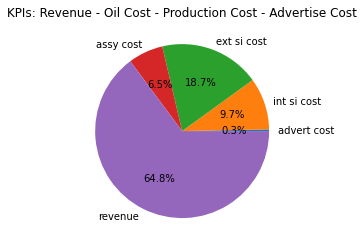

In [26]:
# convert array to pie chart : revenue vs cost
%matplotlib inline
import matplotlib.pyplot as plt
def display_pie(pie_values, pie_labels, colors = None, title = ''):
    plt.axis('equal')
    plt.pie(pie_values, labels = pie_labels, colors = colors, autopct = '%1.1f%%')
    plt.title(title)
    plt.show()

display_pie( [kpnv[1] for kpnv in all_kpis], [kpnv[0] for kpnv in all_kpis], title = 'KPIs: Revenue - Oil Cost - Production Cost - Advertise Cost' )

Oil and Gas details

In [27]:
# how each si is used for each product
mix_values = [[mix[s, p].solution_value for p in range_pr] for s in range_si]
mix_values

[[0, 10000.0, 0], [2500.0, 5500.0, 0], [2000.0, 0, 10000.0]]

In [28]:
# convert array to dataframe
si_disagg_pd = pd.DataFrame(mix_values, columns = pr_names, index = si_names)
si_disagg_pd

,mobile,client,server
int_g1,0.0,10000.0,0.0
int_g2,2500.0,5500.0,0.0
ext_g3,2000.0,0.0,10000.0


In [ ]:
# how each gas is composed by each oil
gas_component_pd = crude_split_pd.T
gas_component_pd

In [28]:
# add summary column for gas_component_pd table
gas_component_pd['sum'] = gas_component_pd[list(gas_component_pd.columns)].sum(axis=1)
gas_component_pd

NameError: name 'gas_component_pd' is not defined

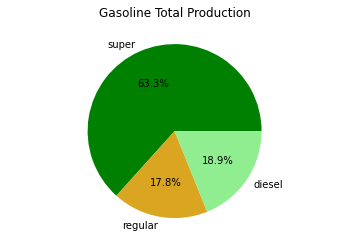

In [126]:
# convert array to pie chart : production
display_pie(gas_component_pd['sum'], gas_names, colors = ['green', 'goldenrod', 'lightGreen'], title = 'Gasoline Total Production')

Breakdown of oil blend quantities per gasoline type

In [127]:
# drop sum
df = gas_component_pd.drop(columns=['sum'])
df

,crude1,crude2,crude3
super,4384.615385,1644.230769,1096.153846
regular,615.384615,1230.769231,153.846154
diesel,0.000000,2125.000000,0.000000


In [1]:
import plotly.express as px
# plotly wide form input: ref(https://plotly.com/python/wide-form/)
fig = px.bar(df, title = 'Gasoline Production',
            labels={'value':'Barrels', 'variable':'Oil Type', 'index':'Gasoline Type'})
fig.show()

NameError: name 'df' is not defined